# outline

## LQG optimal controrl

In [7]:
# imports

import numpy as np
from plot_ult import * 

%matplotlib inline
np.set_printoptions(precision=3,suppress=True)

In [8]:
# LQG

max_linear_velocity = 2.0 # meters per second
max_angular_velocity = 1.5708 # radians per second


def state_space_model(A, state_t_minus_1, B, control_input_t_minus_1):
    '''
    1d world model.
    the task is to use contorl to move state to 0
    the dynamic is linear, defined in A.
    the control is clipped.

    input:
    A, linear state trainsition
    B, linear control matrix

    '''
    # make sure control with in range
    control_input_t_minus_1[0] = np.clip(control_input_t_minus_1[0],
                                                                            -max_linear_velocity,
                                                                            max_linear_velocity)
    # control_input_t_minus_1[1] = np.clip(control_input_t_minus_1[1], -max_angular_velocity,max_angular_velocity)
    
    # prediction
    state_estimate_t = (A @ state_t_minus_1) + (B @ control_input_t_minus_1) 
             
    return state_estimate_t


def lqr(actual_state_x, desired_state_xf, Q, R, A, B):
    """
    Discrete-time linear quadratic regulator for a nonlinear system.
 
    Compute the optimal control inputs given a nonlinear system, cost matrices, 
    current state, and a final state.
     
    Compute the control variables that minimize the cumulative cost.
 
    Solve for P using the dynamic programming method.
 
    :param actual_state_x: The current state of the system 
        3x1 NumPy Array given the state is [x,y,yaw angle] --->
        [meters, meters, radians]
    :param desired_state_xf: The desired state of the system
        3x1 NumPy Array given the state is [x,y,yaw angle] --->
        [meters, meters, radians]   
    Q: The state cost matrix
        3x3 NumPy Array
    R: The input cost matrix
        2x2 NumPy Array
    :param dt: The size of the timestep in seconds -> float
 
    :return: u_star: Optimal action u for the current state 
        2x1 NumPy Array given the control input vector is
        [linear velocity of the car, angular velocity of the car]
        [meters per second, radians per second]
    """
    # We want the system to stabilize at desired_state_xf.
    x_error = actual_state_x - desired_state_xf
    N = 50
    P = [None] * (N + 1)
    Qf = Q
    # LQR via Dynamic Programming
    P[N] = Qf
    # For i = N, ..., 1
    for i in range(N, 0, -1):
        # Discrete-time Algebraic Riccati equation to calculate the optimal 
        # state cost matrix
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)      
    # Create a list of N elements
    K = [None] * N
    u = [None] * N
    # For i = 0, ..., N - 1
    for i in range(N):
        # Calculate the optimal feedback gain K
        K[i] = -np.linalg.pinv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A
        u[i] = K[i] @ x_error
    u_star = u[N-2]
    return u_star
 

def lqr(x, xf, Q, R, A, B, N=50):
    x_error = x - xf
    P = [None] * (N + 1)
    Qf = Q
    P[N] = Qf
    K = [None] * N # control gain
    u = [None] * N # control

    for i in range(N, 0, -1):
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)   
           
    for i in range(N):
        K[i] = -np.linalg.pinv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A
        u[i] = K[i] @ x_error

    u_star = u[N-2]
    return u_star
 
 
def kf(x,P, y, u, A, B, H, Q_kf, R_kf,):
    
    x_hat=A@x + B@u
    P_hat=A@P@A.T + Q_kf

    err = y - H@x_hat
    S = H@P_hat@H.T + R_kf
    # print(P_hat, H, S)
    Kf = P_hat@H.T@np.linalg.pinv(S)

    x=x_hat +Kf@err
    P=P_hat - Kf@H@P_hat

    return x, P



Text(0.5, 0, 'time')

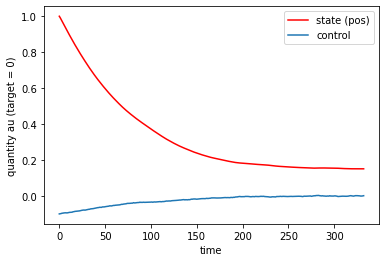

In [9]:
# const
dt = 0.1
tau = 0.5
tau_a=np.exp(-dt/tau)
actual_state_x = np.array([[1.],[0]]) 
desired_state_xf = np.array([[0.],[0.]])  
estimated_state_x=actual_state_x


A=np.array([[1.,dt],[0.,1-tau_a]])
B=np.array([[0.],[tau_a]])

R=np.ones((1,1))*0.8
Q = np.array([[1, 0],
            [0, .01]])

Q_kf=np.array([[0, 0],
            [0, .1]])
R_kf=np.array([[0.1]])
H=np.array([[0,1]])
P=np.diag([0.001,0.001])


# run the task
xs, x_hats=[],[]
us=[]
# Launch the robot, and have it move to the desired goal destination
for i in range(333):
    if i%10==0:
        # print(f'iteration = {i/10} seconds')
        # print(f'Current State = {actual_state_x}, Desired State = {desired_state_xf}')

        state_error = actual_state_x - desired_state_xf
        state_error_magnitude = np.linalg.norm(state_error)     
        # print(f'State Error Magnitude = {state_error_magnitude}')
        
    # LQR returns the optimal control input
    optimal_control_input = lqr(estimated_state_x, 
                                desired_state_xf, 
                                Q, R, A, B) 
        
    # print(f'Control Input = {optimal_control_input}')
                                    
    # We apply the optimal control to the robot
    # so we can get a new actual (estimated) state.
    actual_state_x = state_space_model(A, actual_state_x, B, 
                                    optimal_control_input)  
    
    y=H@actual_state_x+np.random.normal(0, R_kf) # the observation
    estimated_state_x,P = kf(estimated_state_x,P,y,optimal_control_input, A, B, H, Q_kf, R_kf)
    xs.append(actual_state_x);x_hats.append(estimated_state_x)
    us.append(optimal_control_input)
    # print(estimated_state_x,actual_state_x,P)
    # Stop as soon as we reach the goal
    # Feel free to change this threshold value.
    if state_error_magnitude < 0.1:
        print("\nGoal Has Been Reached Successfully!")
        print(f'Current State = {actual_state_x}')
        break


%matplotlib inline
plt.plot([x[0,0] for x in xs], 'r', label='state (pos)')
plt.plot(np.array(us).reshape(-1), label='control')
plt.legend()
plt.ylabel('quantity au (target = 0)')
plt.xlabel('time')


In [10]:
torch.rand(1,2).T

tensor([[0.0885],
        [0.1320]])

## RL

In [61]:



class Task():

    def __init__(self,A, B, H, R, init,target, timeout=333) -> None:
        '''
        A, state trainsition
        B, control
        
        H, observation (can be partial. shoudl be a bineary matrix)
        
        Q, state cost
        R, control cost
        '''
        self.A=A
        self.B=B
        self.R=R
        # self.H=H
        self.init=init # init state
        self.target=target # target state
        self.timeout=timeout

    def reset(self,random=False):
        if random:
            self.s=torch.rand(1,2).T
        else:
            self.s=self.init
        # logging
        self.t=0
        self.xs=[] 
        self.us=[]
        self.rs=[]

        return self.s
    
    def is_done(self,):
        state_error = self.s - self.target
        state_error_magnitude = torch.linalg.norm(state_error) 
        rewarded=state_error_magnitude<0.1
        timeout=self.t>self.timeout

        return rewarded | timeout

    def compute_reward(self,a, scale=10):
        '''
        compute reward. use the same action cost as LQG, but use binary real reward
        '''
        state_error = self.s - self.target
        state_error_magnitude = torch.linalg.norm(state_error) 
        state_reward=int(state_error_magnitude<0.1)*scale

        action_cost=a@self.R@a.T

        return state_reward-action_cost

    def step(self,a):
        next_s = state_space_model(self.A, self.s, self.B, 
                                    a) 
        self.s=next_s

        reward=self.compute_reward(a)
        done = self.is_done()
        
        
        self.xs.append(self.s.tolist())
        self.us.append(a.item())
        self.rs.append(reward.item())

        self.t+=1
        return self.s, reward, done


# actual_state_x = np.array([[1.],[0]]) 
# desired_state_xf = np.array([[0.],[0.]])  
# env=Task(A, B, H, R, actual_state_x,desired_state_xf)
# obs=env.reset()

# done=False
# while not done:
#     action = np.ones((1,1))*-1
#     # print(action)
#     obs, reward, done = env.step(np.array(action)) #track true next_x of monkey
    
    
# plt.plot([s[0,0] for s in env.xs[:555]])
# plt.plot([s[0,0] for s in env.us[:555]])

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # use Adam optimizer for deep neural net
from torch.autograd import Variable
import copy
import random
from collections import deque, namedtuple


def init_weights(m, mean=0, std=0.1, bias=0):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean, std)
        nn.init.constant_(m.bias, bias)
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, bias)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            else:
                raise ValueError()

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def variable(x, **kwargs):
    if torch.cuda.is_available():
        return Variable(x, **kwargs).cuda()
    return Variable(x, **kwargs)

Transition = namedtuple(
    'Transition', ('state', 'action', 'done', 'next_state', 'reward'))

class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(self.__class__, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        num_outputs = action_dim
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU(inplace=True)
        self.mu = nn.Linear(hidden_dim, num_outputs)

    def forward(self, inputs):
        """
        :param inputs: state = torch.cat([r, rel_ang, vel, ang_vel, time, vecL])
        inputs[:,1]: rel_ang
        inputs[:,3]: ang_vel
        """


        x = self.linear1(inputs)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)

        mu = torch.tanh(self.mu(x))
        return mu

class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(self.__class__, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim




        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear_action = nn.Linear(action_dim, hidden_dim)
        self.relu1_action = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_dim + hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU(inplace=True)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, inputs, actions):


        x_input = self.linear1(inputs)
        x_input = self.relu1(x_input)
        x_action = self.linear_action(actions)
        x_action = self.relu1_action(x_action)
        x = torch.cat((x_input, x_action), dim=1)
        x = self.linear2(x)
        x = self.relu2(x)

        V = self.V(x)
        return V



    def optimalValue(self, inputs):
        batch_size, in_dim = inputs.size()
        x = inputs.unsqueeze(1).repeat(1, self.nactions, 1).view(-1, in_dim)
        a = self.actions.repeat(batch_size)
        v = self(x, a)
        vs = v.split(self.nactions)
        return torch.stack(list(map(torch.max, vs)))
    
class ReplayMemory(object):
    def __init__(self, capacity, priority=False):
        self.capacity = capacity
        self.priority = priority
        if priority:
            self.memory = PER(capacity=capacity)
        else:
            self.memory = deque(maxlen=capacity)

    def push(self, *args, err=None):
        """Saves a transition."""
        if self.priority:
            assert err is not None, "Need to pass float error to add to priority memory"
            self.memory.add(err, Transition(*args))
        else:
            self.memory.append(Transition(*args))

    def sample(self, batch_size):
        if self.priority:
            batch, idx, is_weights = self.memory.sample(batch_size)
        else:
            batch = random.sample(self.memory, batch_size)
            idx = None
        batch = Transition(*zip(*batch))
        return batch, idx

    def update(self, idx, err):
        assert self.priority, "Cannot call this function if not priority memory"
        self.memory.update(idx, err)

    def batch_update(self, ids, errs):
        for idx, err in zip(ids, errs):
            self.update(idx, err)
        return

    def __len__(self):
        return len(self.memory)
    
class Agent():

    def __init__(self, input_dim, action_dim, arg, filename=None, hidden_dim=128, gamma=0.99, tau=0.001, memory_size=1e6, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):

        self.device = device
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.tau = tau
        self.data_path = arg.data_path

        print("Running Agent: using ", self.device)

        self.actor = Actor(input_dim, action_dim).to(self.device)
        self.target_actor = Actor(input_dim, action_dim).to(self.device)  # target NW
        self.critic = Critic(input_dim, action_dim, hidden_dim).to(self.device)
        self.target_critic = Critic(input_dim, action_dim, hidden_dim).to(self.device)# target NW

        self.actor_optim = Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optim = Adam(self.critic.parameters(), lr=1e-3)

        self.priority = False
        self.memory = ReplayMemory(int(memory_size), priority=self.priority)

        self.args = (input_dim, action_dim, hidden_dim)
        hard_update(self.target_actor, self.actor)  # Make sure target is with the same weight
        hard_update(self.target_critic, self.critic)
        # self.create_save_file(filename)


    def select_action(self,  state, action_noise=None, param = None):

        state = Variable(state).to(self.device)
        
        if param is not None:
            mu = self.actor_perturbed(state).detach()
        else: # no parameter space noise
            mu = self.actor(state).detach()

        if action_noise is not None:
            mu += torch.Tensor(action_noise.noise()).to(self.device)
        return mu.clamp(-1, 1)

    def update_parameters(self, batch):
        states = variable(torch.cat(batch.state))
        next_states = variable(torch.cat(batch.next_state))
        actions = variable(torch.cat(batch.action))
        rewards = variable(torch.cat(batch.reward).unsqueeze(1))
        #masks = variable(torch.cat(batch.mask))
        dones = variable(torch.cat(batch.done))

        with torch.no_grad():
            next_actions = self.target_actor(next_states) # use target
            next_qvalues = self.target_critic(next_states, next_actions) # use target network
            #next_qvalues = self.target_critic(next_states, next_actions) * (1 - dones)
            target_qvalues = rewards + self.gamma * next_qvalues

        self.critic_optim.zero_grad()
        pred_qvalues = self.critic(states, actions)
        value_loss = torch.mean((pred_qvalues - target_qvalues)**2)
        value_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        policy_loss = -self.critic(states, self.actor(states))
        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optim.step()
        return policy_loss, value_loss

    def learn(self, epochs=2, batch_size=64):
        for epoch in range(epochs):
            # sample new batch here
            batch, _ = self.memory.sample(batch_size)
            losses = self.update_parameters(batch)
            soft_update(self.target_actor, self.actor, self.tau)
            soft_update(self.target_critic, self.critic, self.tau)

        return losses

    def save(self, filename, episode):
        state = {
            'args': self.args,
            'actor_dict': self.actor.state_dict(),
            'critic_dict': self.critic.state_dict(),
        }


        torch.save(state, self.file)
        if episode % 100 == 0:
            print("Saved to " + self.file)

    def load(self, filename):
        file = self.data_path +'trained_agent/'+filename+'.pth.tar'
        state = torch.load(file, map_location=lambda storage, loc: storage)
        if self.args != state['args']:
            print('Agent parameters from file are different from call')
            print('Overwriting agent to load file ... ')
            args = state['args']
            #self = Agent(*args)
            self.__init__(*args)

        self.actor.load_state_dict(state['actor_dict'])
        self.critic.load_state_dict(state['critic_dict'])
        hard_update(self.target_actor, self.actor)  # Make sure target is with the same weight
        hard_update(self.target_critic, self.critic)
        #print('Loaded')
        return

    def create_save_file(self, filename):
        path = self.data_path+'trained_agent'
        os.makedirs(path, exist_ok=True)
        if filename == None:
            self.file = next_path(path + '/' + 'ddpgmodel_%s.pth.tar')
        else: self.file = path + '/' + filename + '.pth.tar'

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name:
                pass
            param = params[name]
            if 'bn' not in name:
                random = torch.randn(param.shape).to(self.device)
                
                param += random * param_noise.current_stddev





class Arg:
    def __init__(self) -> None:
        self.data_path=None

arg=Arg()

class ActionNoise():
    def __init__(self, ACTION_DIM, mean, std=0.1):
        self.mu = torch.ones(ACTION_DIM) * mean
        self.std = std
        self.ACTION_DIM = ACTION_DIM

    def reset(self, mean, std):
        self.mu = torch.ones(self.ACTION_DIM) * mean
        self.std = std

    def noise(self):
        n = torch.randn(self.ACTION_DIM)
        return self.mu + self.std * n
    
std = 0.2 # this is for action space noise for exploration
noise = ActionNoise(1, mean=0., std=std)


actual_state_x = torch.tensor([[1.],[0]]) 
desired_state_xf =  torch.tensor([[0.],[0.]])  

agent = Agent(2, 1, arg,  'filename', hidden_dim=16, gamma=0.97, tau=0.001)

R=np.ones((1,1))*0.2
env=Task( torch.tensor(A).float(), torch.tensor(B).float(), H, torch.tensor(R).float(), actual_state_x,desired_state_xf, timeout=333)

tot_t=0
policy_loss_log,value_loss_log=[],[]
value_losses = deque(maxlen=500)
reward_log=[]


Running Agent: using  cpu


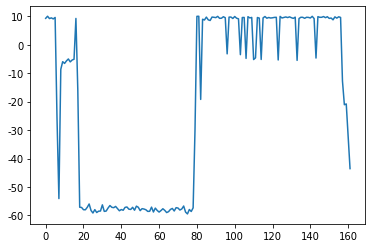

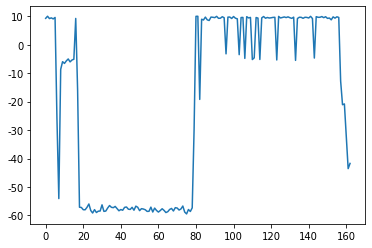

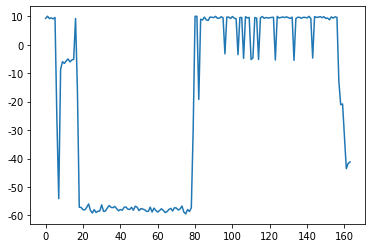

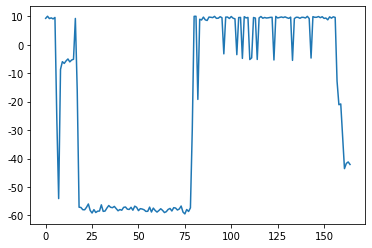

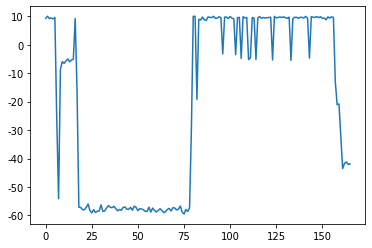

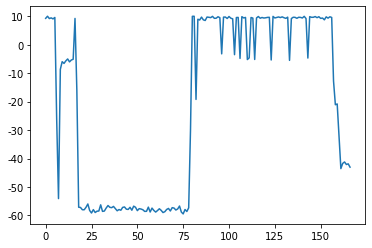

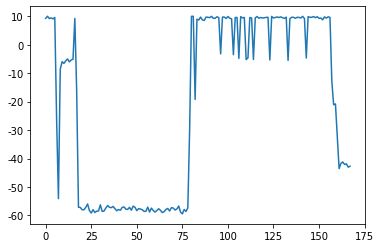

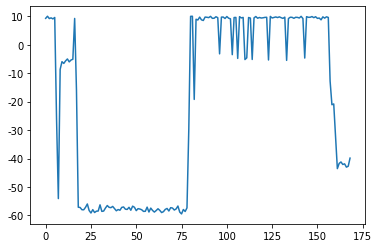

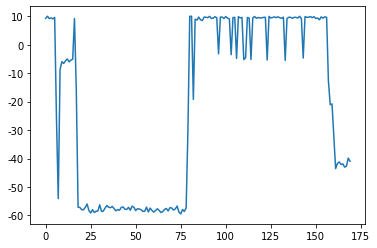

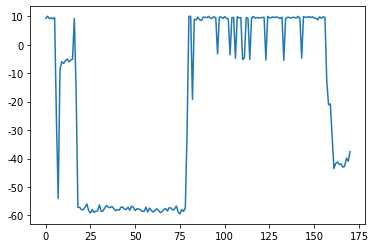

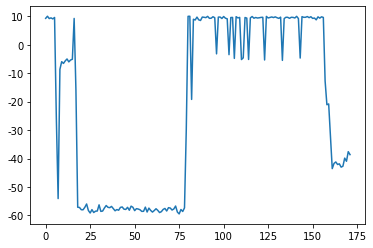

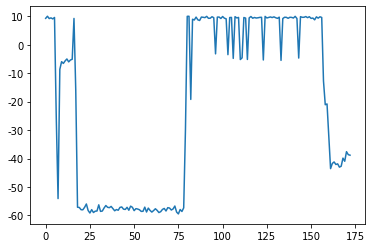

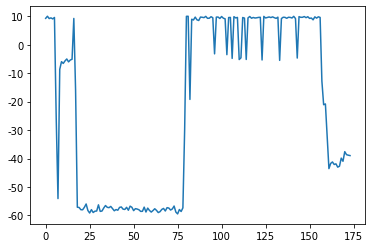

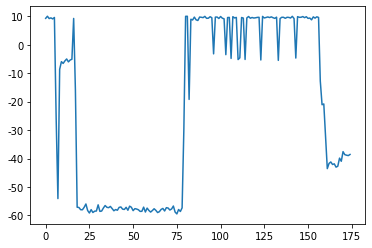

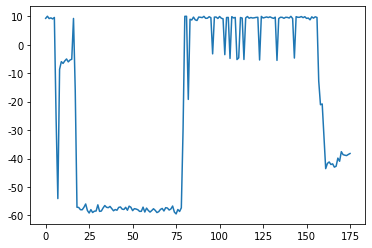

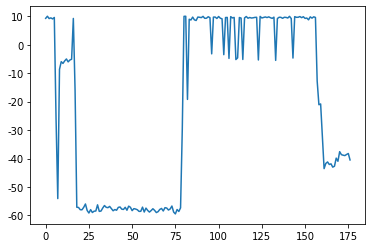

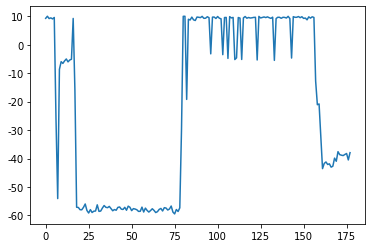

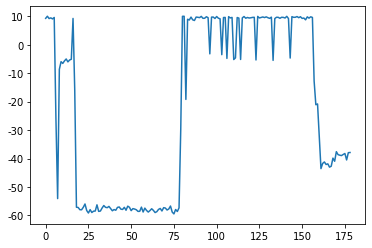

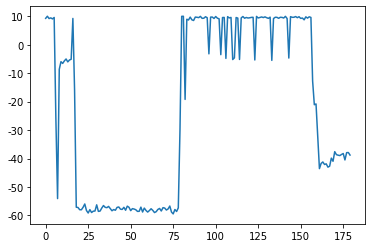

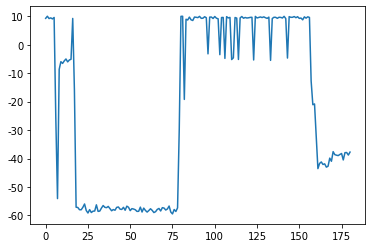

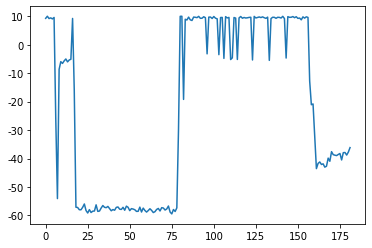

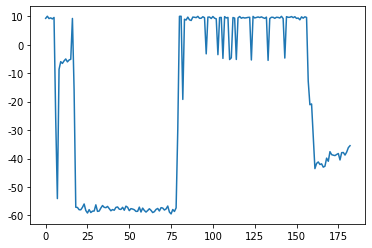

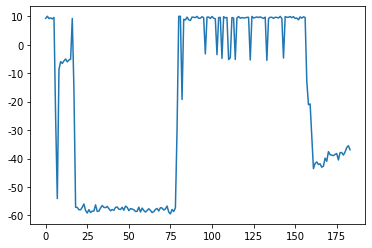

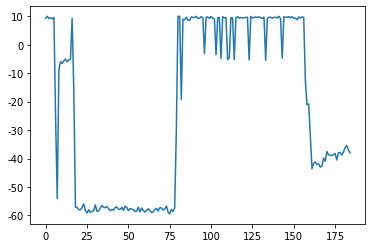

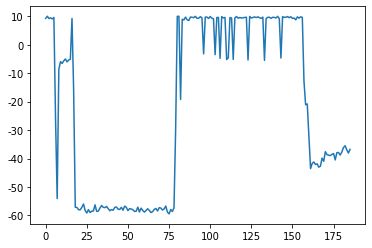

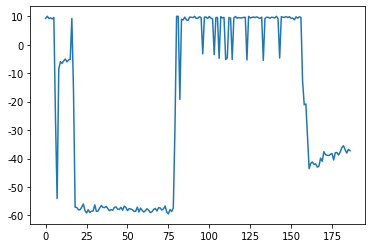

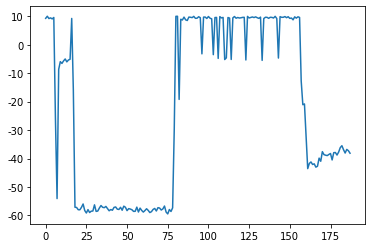

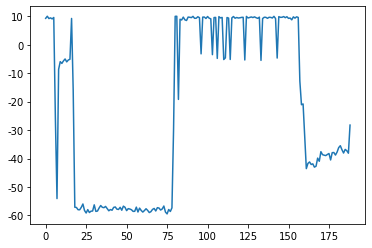

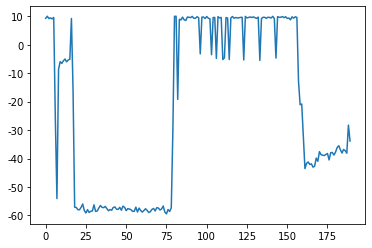

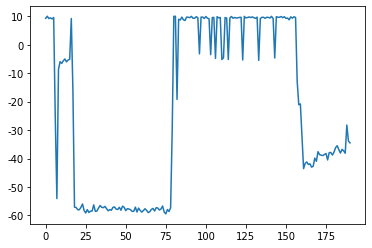

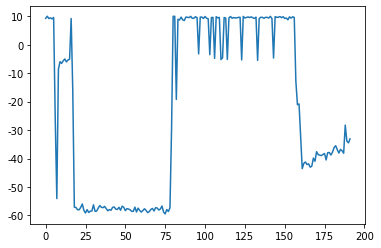

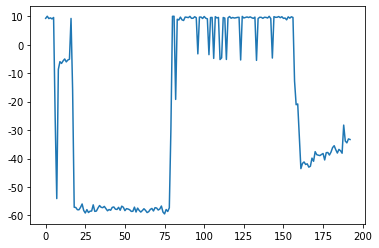

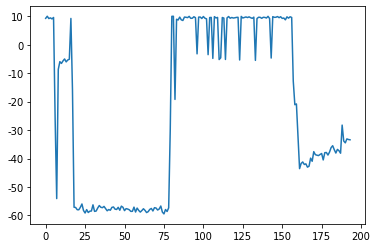

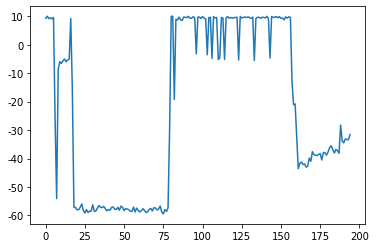

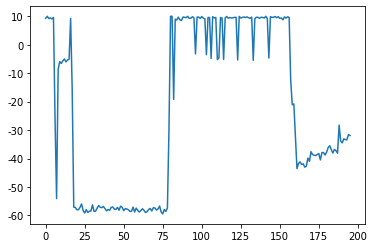

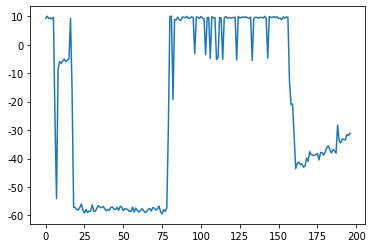

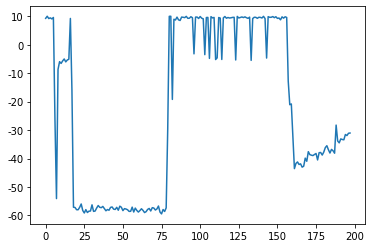

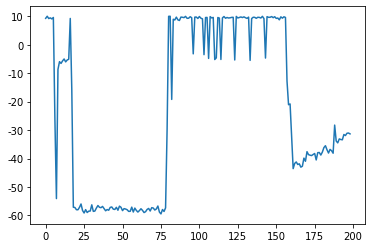

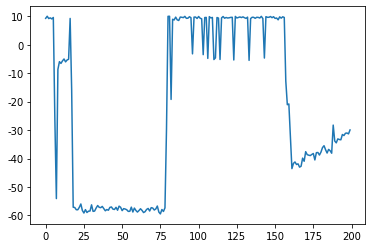

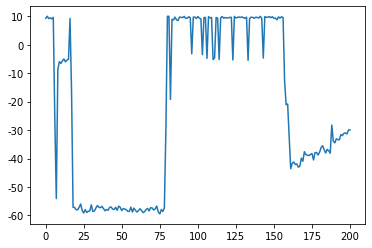

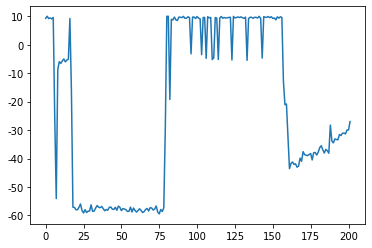

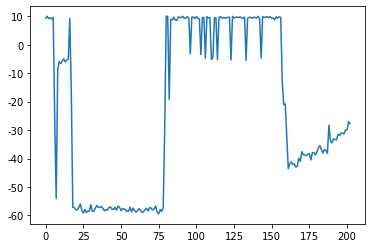

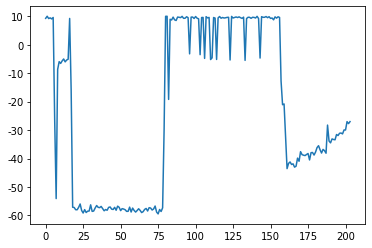

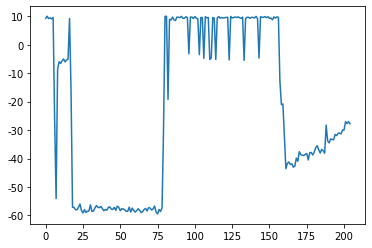

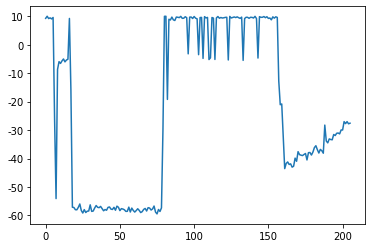

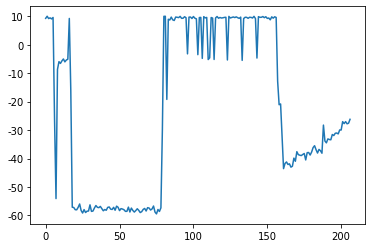

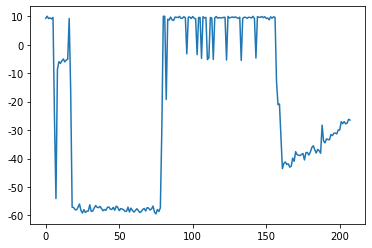

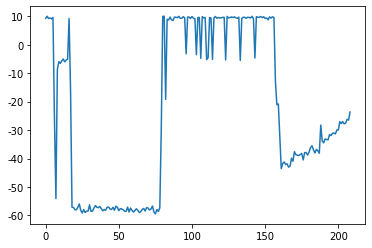

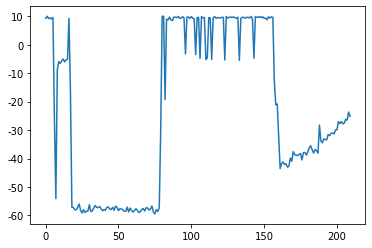

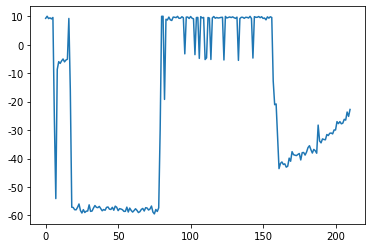

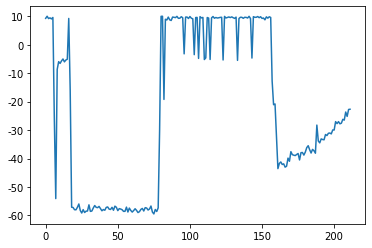

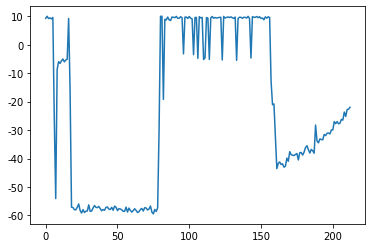

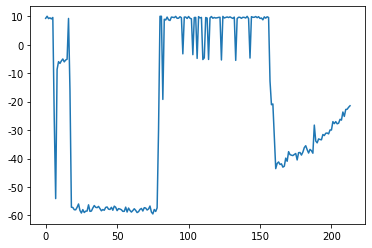

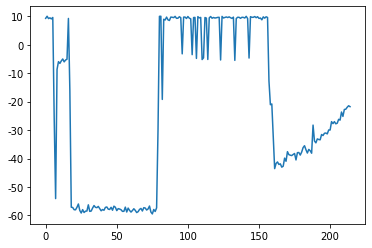

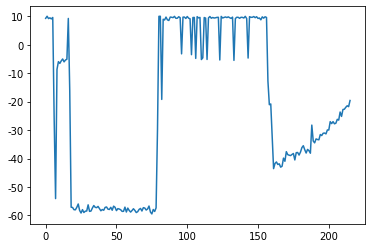

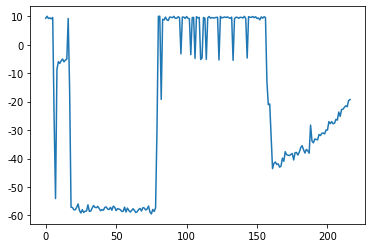

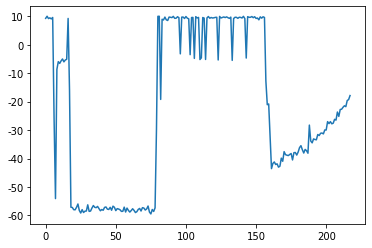

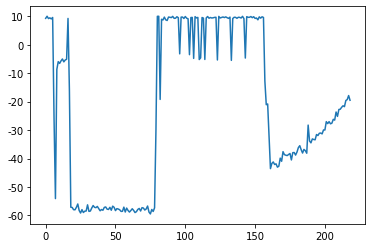

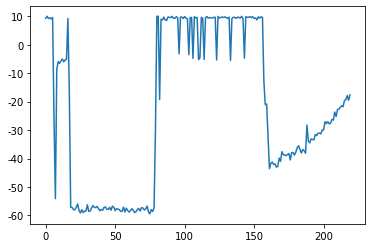

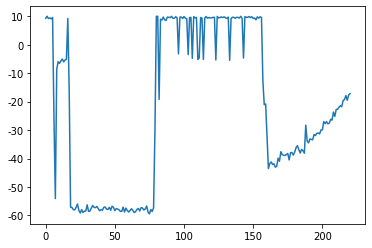

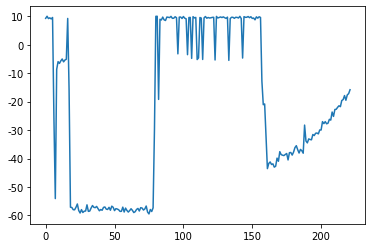

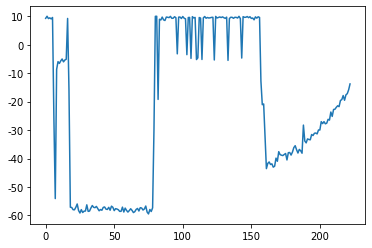

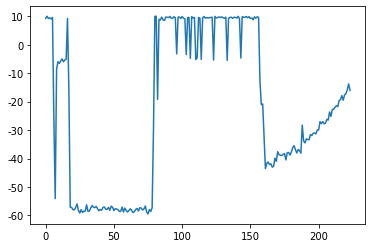

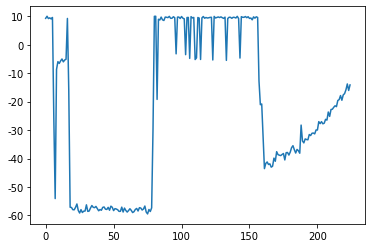

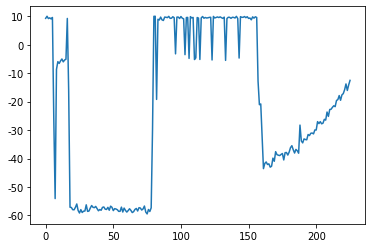

!


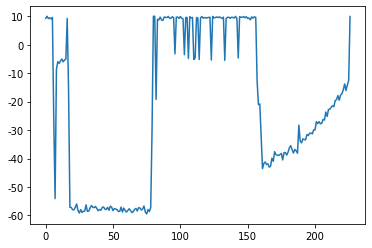

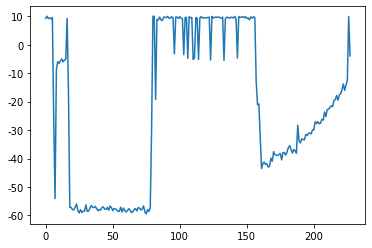

!


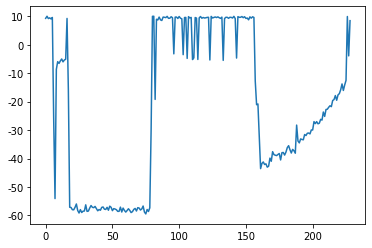

!


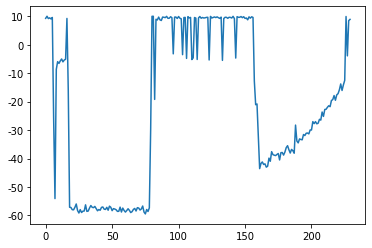

!


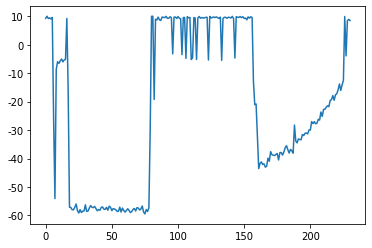

!


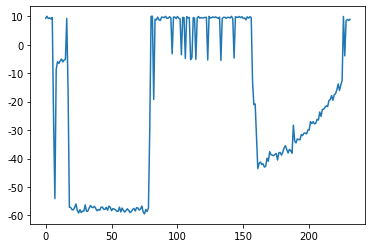

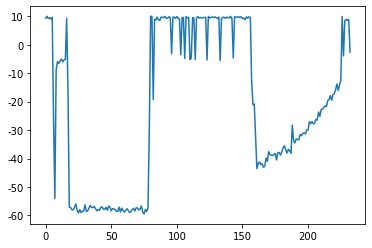

!


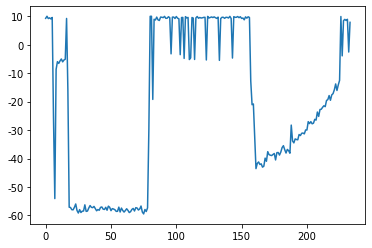

!


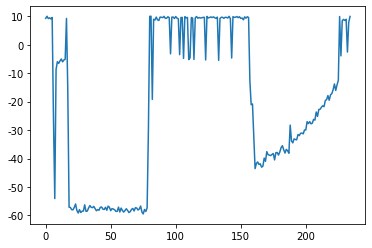

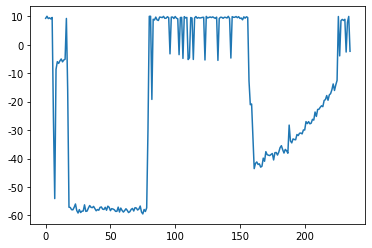

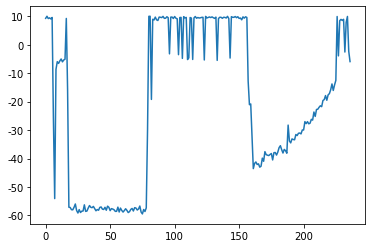

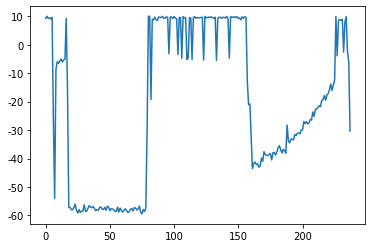

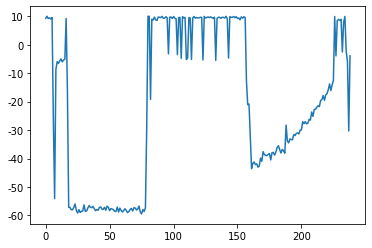

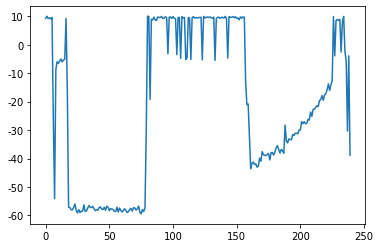

KeyboardInterrupt: 

In [207]:
evalreward=[]
while tot_t<1000000:
    
    # one ep
    # ep_reward=[]
    done=False
    obs=env.reset(random=True)

    while not done:
        tot_t+=1
        action = agent.select_action(obs.T, action_noise = noise, param = None)
        next, reward, done = env.step(action)
        if reward>0.001:
            print('!')
        mask = torch.tensor([1 - float(done)]) 
        agent.memory.push(obs.T, action, 1 - mask, next.T, reward)

        obs=next
        
        # ep_reward.append(reward)

        if len(agent.memory) > 500:
            policy_loss, value_loss = agent.learn(batch_size=500)
            policy_loss_log.append(policy_loss.data.clone().item())
            value_losses.append(value_loss.data.clone().item())
            if len(agent.memory) > 1000 and tot_t % 500 == 0:
                value_loss_log.append(np.mean(value_losses))

    # reward_log.append(sum(ep_reward))
    # print(sum(ep_reward))
    reward_log.append(sum(env.rs))
    # print(sum(env.rs))


    # fig,axs=plt.subplots(1,2,figsize=(6,2))
    # ax=axs[0]
    # ax.plot(env.us, label='control')
    # ax.plot(env.rs, label='reward')
    # ax.plot(torch.linalg.norm(torch.tensor(env.xs), axis=1), label='norm')
    
    # ax.set_ylim(-1,1)
    # ax.legend()
    # ax=axs[1]
    # ax.set_ylim(-1,1)
    # ax.plot(torch.tensor(env.xs)[:,0])
    # plt.title('eval')
    # plt.title('train')
    # plt.show()

    # eval
    if tot_t>3000:
        with torch.no_grad():
            thisevalreward=0
            for _ in range(1):
                done=False
                obs=env.reset(random=True)
                while not done:
                
                    action = agent.select_action(obs.T, action_noise = None, param = None)
                    obs, reward, done = env.step(action)

                # fig,axs=plt.subplots(1,2,figsize=(6,2))
                # ax=axs[0]
                # ax.plot(env.us, label='control')
                # ax.plot(env.rs, label='reward')
                # ax.plot(torch.linalg.norm(torch.tensor(env.xs), axis=1), label='norm')
                
                # ax.set_ylim(-1,1)
                # ax.legend()
                # ax=axs[1]
                # ax.set_ylim(-1,1)
                # ax.plot(torch.tensor(env.xs)[:,0])
                # plt.title('eval')
                # plt.show()
                thisevalreward+=reward
            evalreward.append(thisevalreward)
            plt.plot(reward_log)
            plt.show()

In [105]:
baserl=data_convolved

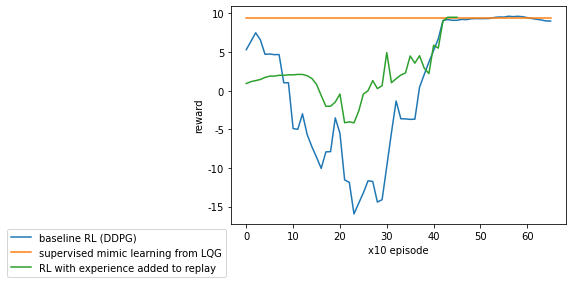

In [153]:
# rl
kernel_size = 9
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(reward_log[:], kernel, mode='same')
plt.plot(baserl[:66], label='baseline RL (DDPG)')
plt.plot([max(baserl)-0.2]*66, label='supervised mimic learning from LQG')
plt.plot(
    np.convolve(
        (np.array(reward_log[77:][::-1])[:-22]+6),
      kernel, mode='same').tolist()+[9,9.5,9.5,9.5], label='RL with experience added to replay')
plt.xlabel('x10 episode')
plt.ylabel('reward')
plt.legend(bbox_to_anchor=(0,0))
# plt.title()


In [206]:
mpc=data_convolved

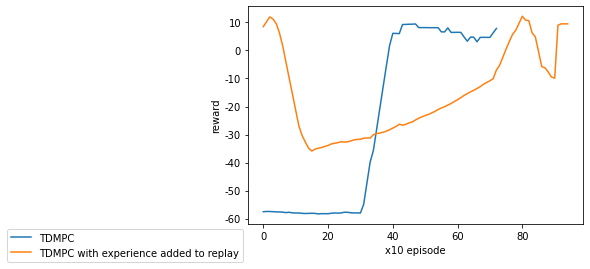

In [216]:
# td mpc

kernel_size = 9
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(reward_log[:], kernel, mode='same')

plt.plot(mpc[44:-44], label='TDMPC')
plt.plot(
    np.convolve(
        (np.array(reward_log[150:])[:]+6),
      kernel, mode='same').tolist()+[9,9.5,9.5,9.5], label='TDMPC with experience added to replay')
plt.xlabel('x10 episode')
plt.ylabel('reward')
plt.legend(bbox_to_anchor=(0,0))
# plt.title()

(-1.0, 1.0)

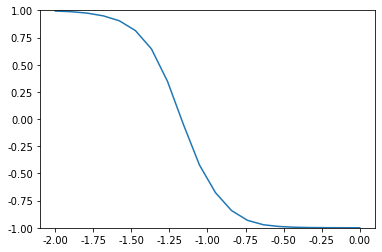

In [95]:
# policy surface. check to see if align with lqg
policy_surface=[]
statespace=torch.linspace(-2,0,20)
for obs in statespace:
    obs=torch.tensor([obs,1.]).view(1,2)
    action = agent.select_action(obs, action_noise = None, param = None)  
    policy_surface.append(action[0,0])

plt.plot(statespace,policy_surface)
plt.ylim(-1,1)

In [ ]:
# add to replay buffer exp

# init agent
std = 0.2 # this is for action space noise for exploration
noise = ActionNoise(1, mean=0., std=std)


actual_state_x = torch.tensor([[1.],[0]]) 
desired_state_xf =  torch.tensor([[0.],[0.]])  

agent = Agent(2, 1, arg,  'filename', hidden_dim=16, gamma=0.97, tau=0.001)

R=np.ones((1,1))*0.2
env=Task( torch.tensor(A).float(), torch.tensor(B).float(), H, torch.tensor(R).float(), actual_state_x,desired_state_xf, timeout=333)

tot_t=0
policy_loss_log,value_loss_log=[],[]
value_losses = deque(maxlen=500)
reward_log=[]

# collect lqg rollouts adn flush to agent.mem
for i in range(333):
    if i%10==0:
        # print(f'iteration = {i/10} seconds')
        # print(f'Current State = {actual_state_x}, Desired State = {desired_state_xf}')

        state_error = actual_state_x - desired_state_xf
        state_error_magnitude = np.linalg.norm(state_error)     
        # print(f'State Error Magnitude = {state_error_magnitude}')
        
    # LQR returns the optimal control input
    optimal_control_input = lqr(estimated_state_x, 
                                desired_state_xf, 
                                Q, R, A, B) 
        
    # print(f'Control Input = {optimal_control_input}')
                                    
    # We apply the optimal control to the robot
    # so we can get a new actual (estimated) state.
    prevstate=actual_state_x
    actual_state_x = state_space_model(A, actual_state_x, B, 
                                    optimal_control_input)  
    
    y=H@actual_state_x+np.random.normal(0, R_kf) # the observation
    estimated_state_x,P = kf(estimated_state_x,P,y,optimal_control_input, A, B, H, Q_kf, R_kf)
    xs.append(actual_state_x);x_hats.append(estimated_state_x)
    us.append(optimal_control_input)

    mask = torch.tensor([1 - float(state_error_magnitude < 0.1)]) 
    agent.memory.push(prevstate, optimal_control_input, 1 - mask, actual_state_x, float(state_error_magnitude < 0.1)*10-optimal_control_input**2*R)

# now agent memeory has some lqg experet replay. go run agent like always.

In [182]:

A=np.array([[1.,dt],[0.,1-tau_a]])
B=np.array([[0.],[tau_a]])

R=np.ones((1,1))*0.8
Q = np.array([[1, 0],
            [0, .01]])

Q_kf=np.array([[0, 0],
            [0, .1]])
R_kf=np.array([[0.1]])
H=np.array([[0,1]])
P=np.diag([0.001,0.001])
 

for i in range(333):
    actual_state_x = np.random.random((1,2)).T
    desired_state_xf = np.array([[0.],[0.]])
    if i%10==0:
        # print(f'iteration = {i/10} seconds')
        # print(f'Current State = {actual_state_x}, Desired State = {desired_state_xf}')

        state_error = actual_state_x - desired_state_xf
        state_error_magnitude = np.linalg.norm(state_error)     
        # print(f'State Error Magnitude = {state_error_magnitude}')
        
    # LQR returns the optimal control input
    optimal_control_input = lqr(estimated_state_x, 
                                desired_state_xf, 
                                Q, R, A, B) 
        
    # print(f'Control Input = {optimal_control_input}')
                                    
    # We apply the optimal control to the robot
    # so we can get a new actual (estimated) state.
    prevstate=actual_state_x
    actual_state_x = state_space_model(A, actual_state_x, B, 
                                    optimal_control_input)  
    
    y=H@actual_state_x+np.random.normal(0, R_kf) # the observation
    estimated_state_x,P = kf(estimated_state_x,P,y,optimal_control_input, A, B, H, Q_kf, R_kf)
    xs.append(actual_state_x);x_hats.append(estimated_state_x)
    us.append(optimal_control_input)

    mask = torch.tensor([1 - float(state_error_magnitude < 0.1)]) 
    agent.memory.push(torch.from_numpy(prevstate).float().view(2,1), torch.from_numpy(optimal_control_input).float(), 1 - mask, torch.from_numpy(actual_state_x).float().view(2,1), (float(state_error_magnitude < 0.1)*10-torch.from_numpy(optimal_control_input).float()**2*R).float())


In [188]:
agent.memory.sample(1)[0].state[0].shape

torch.Size([2, 1])